In [24]:
import torch
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import numpy as np
import os

torch.manual_seed(777)  # reproducibility

In [25]:
from __future__ import division

In [26]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [27]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
import torchvision.models as models

from PIL import Image


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import random
import time
import os
import cv2
#from skimage.io import imread

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [29]:
torch.cuda.device_count()

2

In [30]:
# hyper-parameters
bs = 32
keep_prob = 0.2 # 0.7

In [31]:
model_conv = torch.load('Base_AlexNet.pt').cuda()

#similarly you can load other base pretrained models for fine-tuning on thermal data

In [32]:
for param in model_conv.parameters():
    print(param.size())

torch.Size([64, 3, 11, 11])
torch.Size([64])
torch.Size([192, 64, 5, 5])
torch.Size([192])
torch.Size([384, 192, 3, 3])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([4096, 9216])
torch.Size([4096])
torch.Size([4096, 4096])
torch.Size([4096])
torch.Size([2, 4096])
torch.Size([2])


In [33]:
print (model_conv)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [34]:
# Freeze or unfreez model parameters
for param in model_conv.parameters():
    param.requires_grad = True

In [35]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 0.6)),
        #transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=250),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        #transforms.Grayscale(num_output_channels=3),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=250),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=250),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [36]:
# Load the Data
import os
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
from torch.optim import lr_scheduler

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

# Set train and valid directory paths

dataset = '/home/gwy-dnn/ali/py-torch-gender-calssification/Gender-Classification-Github-Repo/Datasets/male-female-orignal'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')

# Batch size
bs = 32

# Number of classes
#num_classes = len(os.listdir(valid_directory))-1  #10#2#257
#num_classes = len(os.listdir(valid_directory)) #10#2#257
num_classes = 2
print(num_classes)

# Load Data from folders
#data = {
#    'train': datasets.ImageFolder(root=train_directory, transform=transformations),
#    'valid': datasets.ImageFolder(root=valid_directory, transform=transformations),
#    'test': datasets.ImageFolder(root=test_directory, transform=transformations)
#}

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

items = iter(train_data_loader)
image, label = items.next()

2
{0: 'FEMALE', 1: 'MALE'}


In [38]:
train_data_size, valid_data_size, test_data_size

(746, 232, 90)

In [39]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)

#For using other optimizers and loss_func
#loss_func = nn.NLLLoss()
#optimizer = optim.Adam(model_conv.parameters())

In [17]:
def show_transformed_image(image):
    np_image = image.numpy()
    plt.figure(figsize=(40,40))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


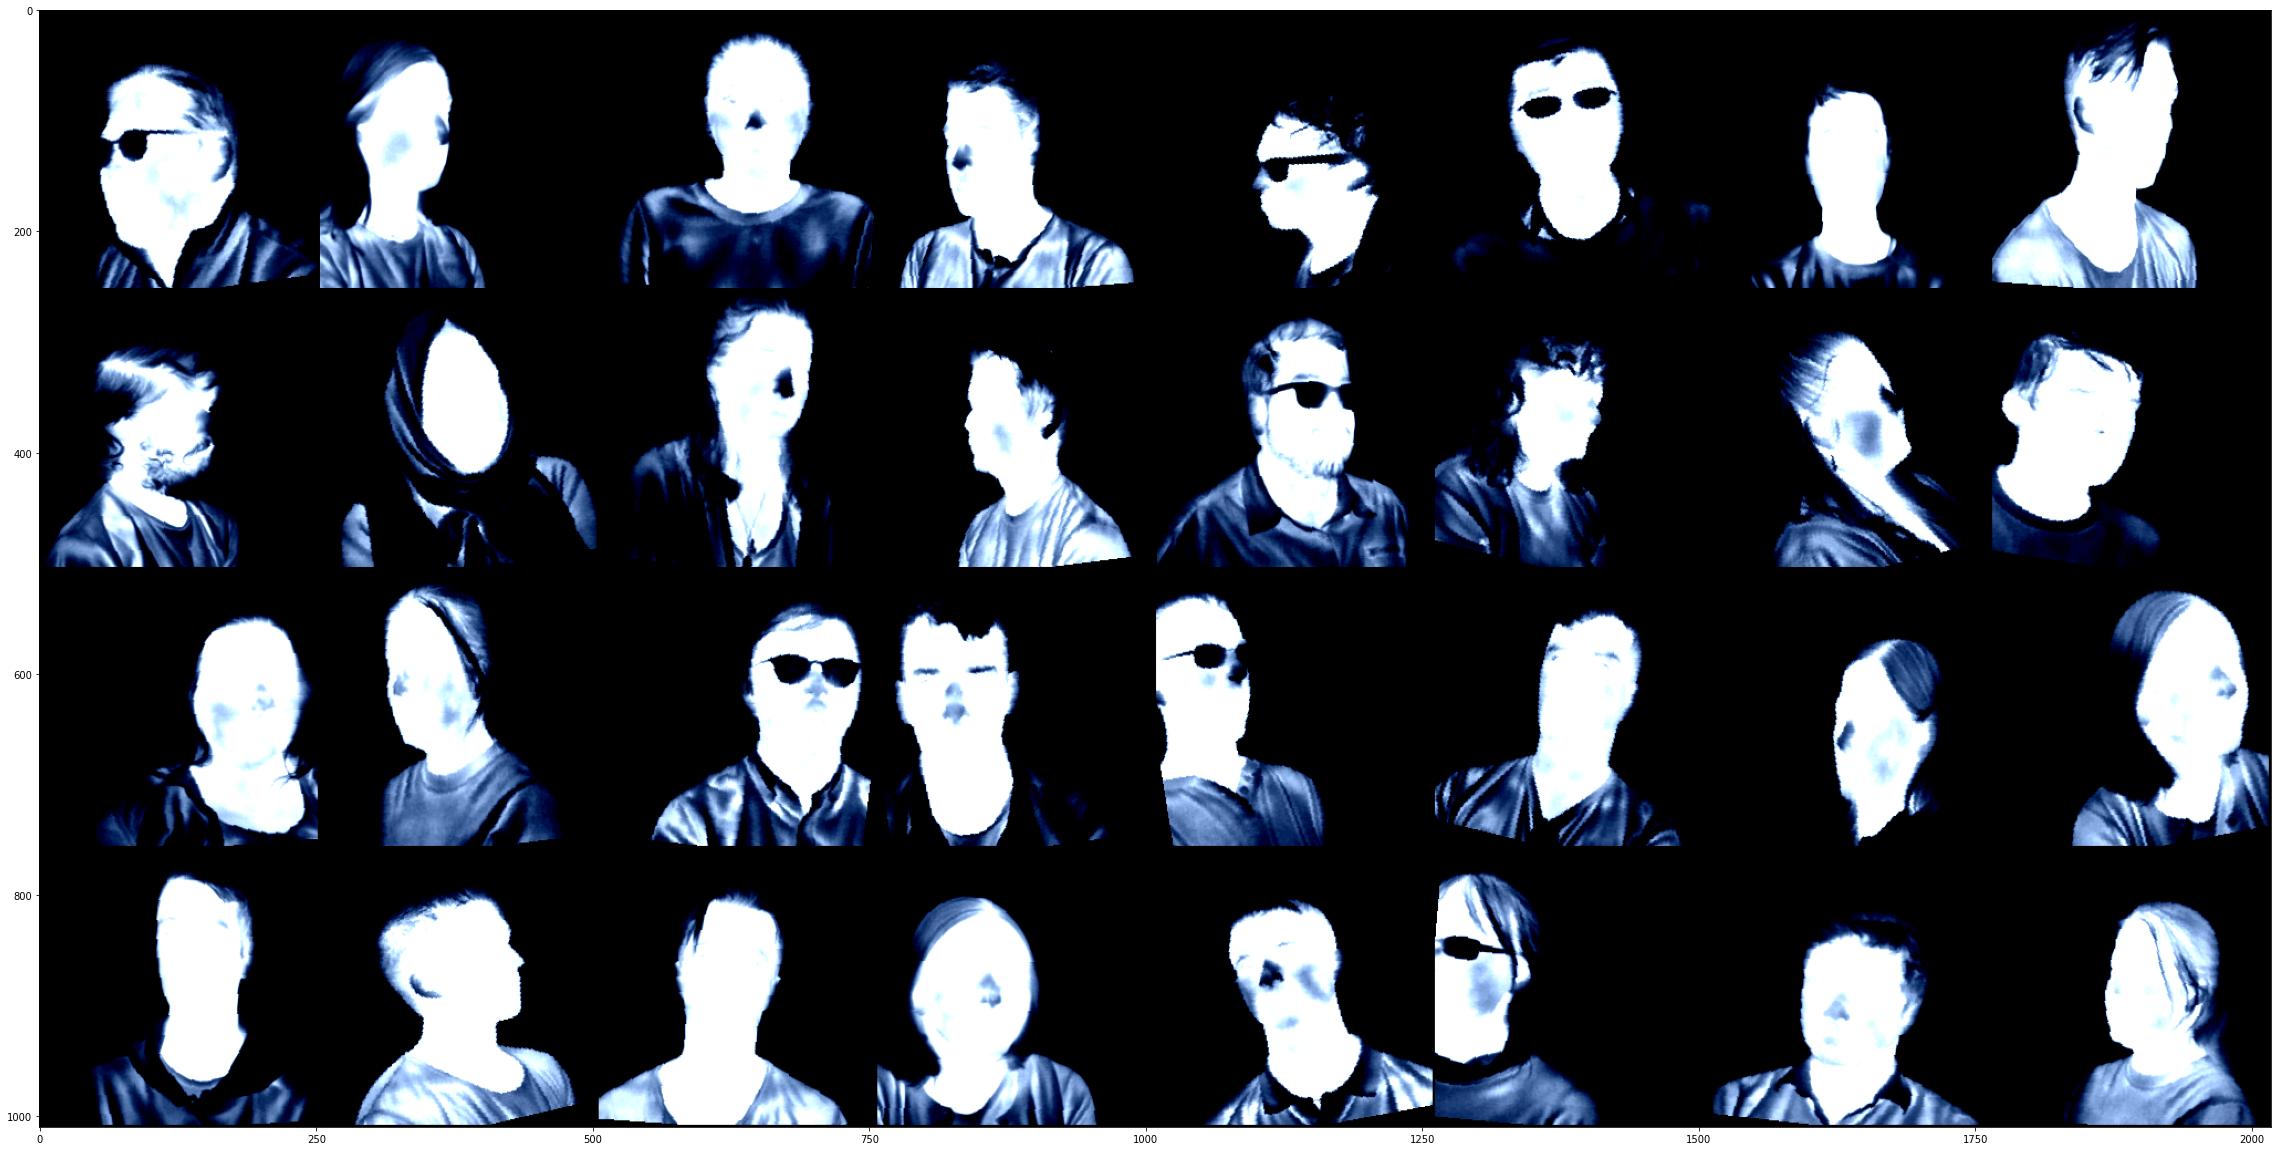

In [19]:
from torchvision.utils import make_grid
show_transformed_image(make_grid(image))

In [20]:
def train_and_validate(model, loss_criterion, optimizer, epochs=10):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=10)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            #outputs = model(inputs)
            outputs = model(inputs)
            
            # Compute loss
            #loss = loss_criterion(outputs, labels)
            loss = loss_func(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)
                #print outputs.size()
                #print inputs.size()
                #print labels

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [2]:
print ('Note: Dont run next three cells as it will start the training process') 
print ('if you want to retrain the model run the below cell')

Note: Dont run next three cells as it will start the training process
if you want to retrain the model run the below cell


In [ ]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device = torch.device("cuda")

# Print the model to be trained
#summary(model_conv, input_size=(3, 250, 250), batch_size=32, device="cuda")
#summary(model_conv, input_size=(3, 250, 250), batch_size=bs, device='cpu') for running model on cpu

# Train the model for 25 epochs
num_epochs = 100
trained_model, history = train_and_validate(model_conv, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

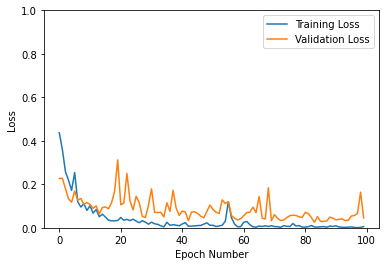

In [84]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

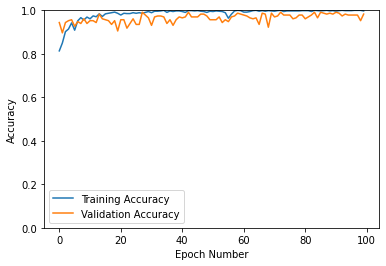

In [85]:
plt.plot(history[:,2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [18]:
#for testing the trained model on whole test data i.e carl+lab test data
import torch

test_acc_count = 0
for k, (test_images, test_labels) in enumerate(test_data_loader):
    model = torch.load('/home/gwy-dnn/ali/py-torch-gender-calssification/Gender-Classification-Github-Repo/ADAM/AlexNet/Results/male-female-orignal_model_95.pt')
    #model = torch.load('/home/gwy-dnn/ali/py-torch-gender-calssification/Gender-Classification-Github-Repo/Datasets/SGD/Alexnet-F/Results/Un-frezeed Results/male-female-orignal_model_50.pt')
    model.cpu()
    #test_outputs = model_conv(test_images)
    test_outputs = model(test_images)
    _, prediction = torch.max(test_outputs.data, 1)
    test_acc_count += torch.sum(prediction == test_labels.data).item()
    
a = test_acc_count
print (a) 

b = test_data_size
print (b)
test_accuracy = (a / b)*100

print ('The total test accuracy of trained model is')
print (test_accuracy)

/home/gwy-dnn/ali/project/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


73
90
The total test accuracy of trained model is
81.11111111111111


In [19]:
def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))

In [20]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)
    #test_image_tensor = test_image_tensor.view(1, 3, 224, 224)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 250, 250).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 250, 250)
            
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(2, dim=1)
        for i in range(1):
            print("Output class :  ", idx_to_class[topclass.cpu().numpy()[0][0]], ", Score: ", topk.cpu().numpy()[0][i]*0.4)
            #print("Output class :  ", "FEMALE", ", Score: ", 0.93432104)


In [40]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 250, 250).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 250, 250)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(2, dim=1)
        for i in range(1):
            print("Model: AlexNet, Prediction",":", idx_to_class[topclass.cpu().numpy()[0][i]])

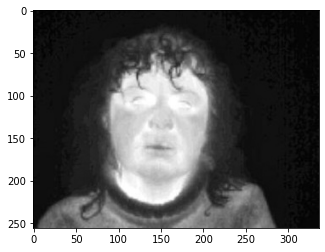

Model: AlexNet, Prediction : MALE


In [41]:
#For testing the model on single test image (inference on one image)

from PIL import Image
# Test a particular odel on a test image

dataset = 'Datasets/tufts-data'
model = torch.load('AlexNet.pt')
model.cuda() 

plt.ioff()
plt.show()

predict(model, 'test/5.jpg')


# Load Data from folders
#computeTestSetAccuracy(model, loss_func)